# Superoperator checks

In [30]:
from itertools import product
import matplotlib.pyplot as plt

import time
import numpy as np
import cmath
import pysqkit
from typing import List, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import qutip as qtp

import pysqkit.util.transformations as trf
from pysqkit.util.linalg import hilbert_schmidt, tensor_prod

from IPython.display import display, Latex

## I now check TomoEnv class
We consider a fluxonium transmon system

In [31]:
levels_f = 5
levels_t = 3
d_comp = 4
d_leak = levels_t*levels_f - d_comp
flx = pysqkit.qubits.Fluxonium(label='F', charge_energy=.973, induct_energy=.457, 
                               joseph_energy=8.0, flux=1/2, dim_hilbert=100)
trans = pysqkit.qubits.SimpleTransmon(label='T', max_freq=4.5, 
                                      anharm=-0.3, dim_hilbert=levels_t)

flx.diagonalize_basis(levels_f)
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t, eig_states_t = trans.eig_states(levels_t)  

In [32]:
#Drive
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

In [33]:
jc = 0.07
coupled_sys = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_sys.eig_states() 

coupled_sys_bare = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_sys_bare.eig_states()
    
energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        energies_in_lexico[count] = energies_t[k] + energies_f[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)
label_converter = ascending_to_lexico

In [34]:
def label_to_states(
    k: int, 
    m: int,
    levels_f: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

In [35]:
eig_states_by_label = []
energies_by_label = []
for i_a in range(levels_t):
    energies_by_label.append([])
    eig_states_by_label.append([])
    for i_b in range(levels_f):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels_f, eigstates_sys, label_converter), 
                                                 dims=[[levels_t, levels_f], [1, 1]], shape=[levels_t*levels_f, 1]))
        energies_by_label[i_a].append(label_to_states(i_a, i_b, levels_f, energies_sys, label_converter))

In [36]:
eps_f = 0.03091755984900732
freq_drive = 7.155
t_rise = 15 #16.0
t_tot = 60 #60 # 60
pts_per_drive_period = 15 #5 recommended #15 more accuracy

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [0,3], [1,3], [2,0]]
labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

hamil0 = coupled_sys.hamiltonian(as_qobj=True)
coupled_sys['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, 
                                                 amp=eps_f, freq=freq_drive)

In [37]:
drive_hamils = []
pulses = []

for qubit in coupled_sys:
    if qubit.is_driven:
        for label, drive in qubit.drives.items():
            drive_hamils.append(drive.hamiltonian(as_qobj=True))
            pulses.append(drive.eval_pulse())

In [38]:
temperature = 0.020 # K
en_th = pysqkit.util.phys.temperature_to_thermalenergy(temperature) # kb T/h in GHz
tan_deltac_f = 7.1*1e-6 
tan_deltac_t = 0.75*1e-6
qdiel_f = 1/tan_deltac_f
qdiel_t = 1/tan_deltac_t
trans_jumps = trans.dielectric_loss(qdiel_t, 1/en_th, as_qobj=True)
flx_jumps = flx.dielectric_loss(qdiel_f, 1/en_th, as_qobj=True)
jumps = []
for op in trans_jumps:
    jumps.append(qtp.tensor(op, qtp.qeye(levels_f)))
for op in flx_jumps:
    jumps.append(qtp.tensor(qtp.qeye(levels_t), op))

In [39]:
start = time.time()

state_in = []
outputs = []
for i in range(0, 2):
    for k in range(0, 2):
        state_in.append(eig_states_by_label[i][k])
for i in range(0, 4):
    outputs.append(pysqkit.solvers.solvkit.integrate(tlist*2*np.pi, state_in[i], hamil0, drive_hamils, pulses, jumps, "mesolve"))
    
end = time.time()

print("Computation time = " , end - start, "seconds")

Computation time =  3.7167179584503174 seconds


In [40]:
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j]*eig_states_by_label[i][j].dag())  

plot_setup = {'lw': 2.0, 'fs': 16, 'fs_text': 14, 'ls': 14}
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray,
    opt: dict
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = (16, 8))
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist, probs[k, :], linewidth=opt['lw'])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k], fontsize=opt['fs'])
        ax[k//4, k%4].set_ylim(-0.1, 1.1)
        ax[k//4, k%4].axhline(y=0, color='grey', linestyle='--')
        ax[k//4, k%4].axhline(y=1, color='grey', linestyle='--')

        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    plt.show()
        

We introduce the TomoEnv object

In [41]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-10
simu_opt.rtol = 1e-8
env_syst = pysqkit.tomography.TomoEnv(system = coupled_sys, jump_op=jumps, options=simu_opt)

In [42]:
comp_states = [eig_states_by_label[0][0][:], eig_states_by_label[0][1][:], eig_states_by_label[1][0][:], \
               eig_states_by_label[1][1][:]]
proj_comp = 0
for n in range(0, 2):
    for m in range(0, 2):
        proj_comp += eig_states_by_label[n][m]*eig_states_by_label[n][m].dag()

In [43]:
start = time.time()
sup_op = env_syst.to_super(comp_states, trf.weyl_by_index)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 83.70965456962585 s


Now we check that the probability of finding the system in one of the computational basis states given a certain initial state agrees with the corresponding calculation using the superoperator representation.

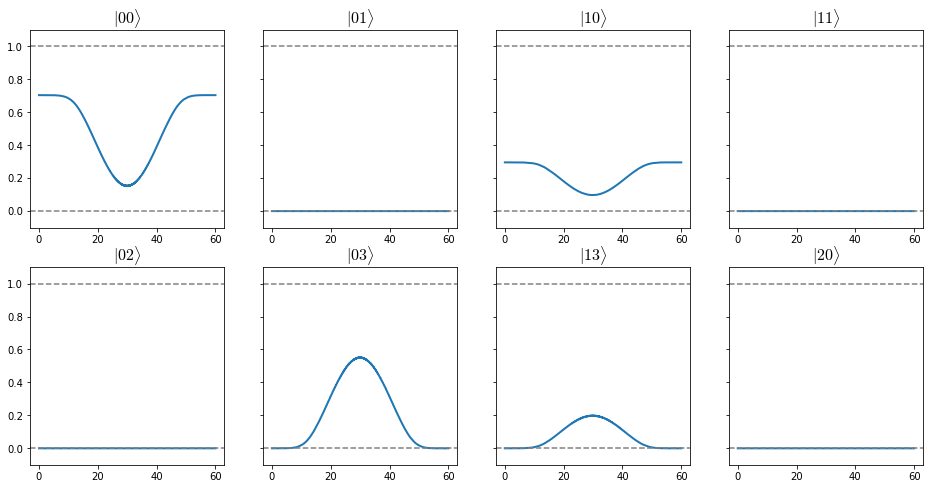

In [44]:
theta = 20
ket_in = np.cos(theta/2)*eig_states_by_label[0][0] - np.sin(theta/2)*eig_states_by_label[1][0] 
rho_in = ket_in*ket_in.dag()
output = pysqkit.solvers.solvkit.integrate(tlist*2*np.pi, rho_in, hamil0, drive_hamils, pulses, \
                                           [], "mesolve", options=simu_opt)
rho_fin = output.states[-1]

probs_out = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, len(labels)):
    i, j = interest_levels[k]
    for m in range(0, nb_points):        
        probs_out[k, m] = qtp.expect(rhos_by_label[i][j], output.states[m]) 

plot_probas(tlist, probs_out,  plot_setup)
leakage = 1 - qtp.expect(proj_comp, output.states[-1])

In [45]:
display(Latex(r'$\mathrm{{Leakage}} = {:.5f}$'.format(leakage)))

<IPython.core.display.Latex object>

Using the superoperator

In [46]:
basis = [] 
d = len(comp_states)
for i in range(0, d**2):
    basis.append(trf.iso_basis(i, comp_states, trf.weyl_by_index))
rho_in_vec = np.zeros(d**2, dtype=complex)
for i in range(0, d**2):
    rho_in_vec[i] = hilbert_schmidt(basis[i], rho_in[:, :])
rho_fin_vec = sup_op.dot(rho_in_vec)
rho_fin_from_sup = 0
for i in range(0, d**2):
    rho_fin_from_sup += rho_fin_vec[i]*basis[i]
# rho_fin_check = 0

# start = time.time()

# for i in range(0, d**2):
#     evolved_basis_i = env_syst.evolve_hs_basis(i, comp_states, trf.weyl_by_index)
#     rho_fin_check += rho_in_vec[i]*evolved_basis_i

# end = time.time()
# print("Computational time = " + str(end - start) + ' s')

We now compute the fidelity between the state computed using the direct master equation simulation and the superoperator. I first remark that

In [47]:
qtp.fidelity(rho_fin, rho_fin)

1.0000425243838609

so there is still some numerical issue here.

In [48]:
qtp.fidelity(rho_fin, qtp.Qobj(inpt=rho_fin_from_sup, dims=[[3, 5], [3, 5]]))

0.9978306979790892

The fidelity looks ok. However, I remark that using the previous commented code to compute rho_fin_check should give exactly the same result as using superoperator. Yet, we seem to lose accuracy with the superoperator somewhere.

Thus, the result is accurate given the the numerical accuracy. Also, notice that we expect the previous quantity to be 1 only when we have low leakage. We now get the single-qubit corrections directly from the superoperator.

In [49]:
def single_qubit_corrections(
    sup_op: np.ndarray,
    hs_basis: Callable[[int, int], np.ndarray]
) -> np.ndarray:
    sigma_m1 = tensor_prod([np.array([[0.0, 0.0], [1.0, 0.0]]), np.array([[1.0, 0.0], [0.0, 0.0]])])
    sigma_m2 = tensor_prod([np.array([[1.0, 0.0], [0.0, 0.0]]), np.array([[0.0, 0.0], [1.0, 0.0]])])
    sigma_m1_vec = trf.mat_to_vec(sigma_m1, hs_basis)
    sigma_m2_vec = trf.mat_to_vec(sigma_m2, hs_basis)
    evolved_sigma_m1_vec = sup_op.dot(sigma_m1_vec)
    evolved_sigma_m2_vec = sup_op.dot(sigma_m2_vec)
    evolved_sigma_m1 = trf.vec_to_mat(evolved_sigma_m1_vec, hs_basis)
    evolved_sigma_m2 = trf.vec_to_mat(evolved_sigma_m2_vec, hs_basis)
    phi10 = cmath.phase(hilbert_schmidt(sigma_m1, evolved_sigma_m1))
    phi01 = cmath.phase(hilbert_schmidt(sigma_m2, evolved_sigma_m2))
    p_phi10 = np.array([[1, 0], [0, np.exp(-1j*phi10)]])
    p_phi01 = np.array([[1, 0], [0, np.exp(-1j*phi01)]])
    return tensor_prod([p_phi10, p_phi01])
    

We now compute the process fidelity

In [50]:
cz = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
cz_super = trf.kraus_to_super(cz, trf.weyl_by_index)
sq_corr = single_qubit_corrections(sup_op, trf.weyl_by_index)
sq_corr_sup = trf.kraus_to_super(sq_corr, trf.weyl_by_index)
total_sup_op = sq_corr_sup.dot(sup_op)

def average_process_fidelity(
    sup_op1: np.ndarray,
    sup_op2: np.ndarray
) -> complex:
    d = sup_op1.shape[0]
    return np.trace(sup_op1.conj().T.dot(sup_op2))/d

process_fidelity = average_process_fidelity(cz_super, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(process_fidelity)))

<IPython.core.display.Latex object>